# Predict House Sale Value for Homes in King County, USA

Use the Kaggle Dataset https://www.kaggle.com/harlfoxem/housesalesprediction to predict house prices.

Project Outcomes:
1. Use vsualizations to show patterns and relationships in the dataset
2. Use Multiple machine learning techniques and compare the accuracy of the methods
3. Optimize and display the best method for prediction house price and a summary of the most important features in the dataset.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Read King County data to a dataframe and add column names to a list
df = pd.read_csv('kc_house_data.csv')
#print(df.head())
colNames = list(df)
print(colNames)

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


# View House Location Distribution

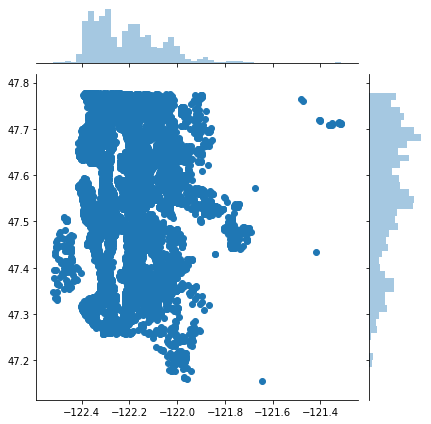

In [5]:
# location map, houses can be located by georeference of latitude and Longitude. 
#You can see the shoreline feature!
sns.jointplot(x=df.long.values,y=df.lat.values,size=6)

# How Big is Big? Review of Lot and House size

The lot size does not appear correlated at first glance.  This must be due to some kind of partitioning for condos and townhouses. 
sqft_lving has the highest correlation, but is highly correlated with sqft_above and sqft_living15.

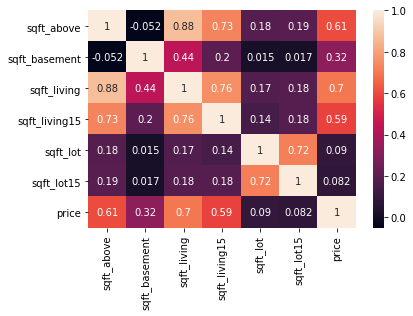

In [7]:
dftemp = df[['sqft_above', 'sqft_basement', 'sqft_living','sqft_living15','sqft_lot', 'sqft_lot15','price']]

plt.figure(figsize=(6,4))
sns.heatmap(dftemp.corr(),annot=True)

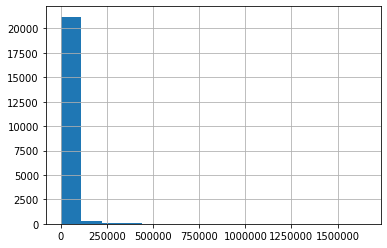

In [8]:
# Review distribution of lot sizes.  
# Some very large parcels of land were sold in 2014/2015, however the vast majority are under 12,000 sqft
df['sqft_lot'].hist(bins=15)

In [9]:
#There are 3 rows with very small lot sizes, infact, the house size as listed wouldn't fit on the lot!
df[df.sqft_lot  <= 600]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5826,1773101159,20150107T000000,250000.0,3,2.25,1050,572,2.0,0,0,...,7,740,310,2006,0,98106,47.5549,-122.363,1260,1062
7589,6371000026,20150122T000000,367500.0,2,2.00,1030,600,2.0,0,0,...,8,680,350,2004,0,98116,47.5788,-122.410,1120,1267
15743,9828702895,20141022T000000,700000.0,4,1.75,2420,520,1.5,0,0,...,7,2420,0,1900,0,98112,47.6209,-122.302,1200,1170


Poor relationship to the size of the lot, feature removed form initial analysis




# House Features


## Living space and location, location, location

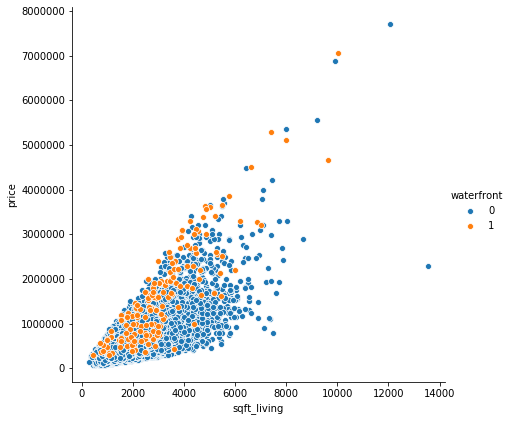

In [12]:
# For the same size house, homes located on the water (orange) are priced higher
sns.pairplot(df,x_vars=['sqft_living'], y_vars=['price'],hue='waterfront',size=6)

Note the linear cap to the prices, regardless of the house size. There are outliers to lower prices, not a single one higher  


## Bedrooms:
Number of bedrooms is signifigant to home price. 3 bedrooms is typical to King County houses. 

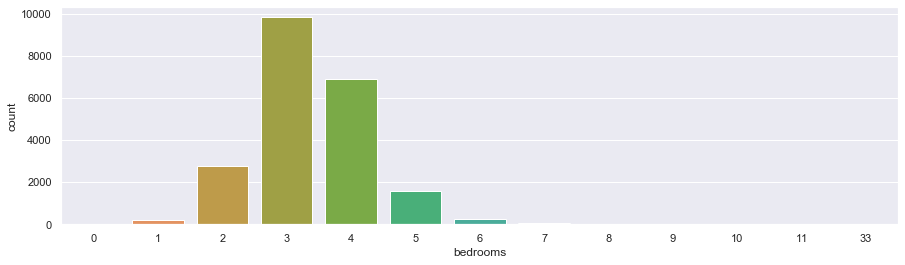

In [13]:
plt.figure(figsize=(15,4))
sns.set(style="darkgrid")
ax = sns.countplot(x="bedrooms", data=df)

Some adjustment to Bedroom data required: 
This analysis removed homes with no bedrooms (as those would be special cases) and the entry with 33, as the entry in general is abnormality based on size of house, lot size and supposedly 33 bedrooms.

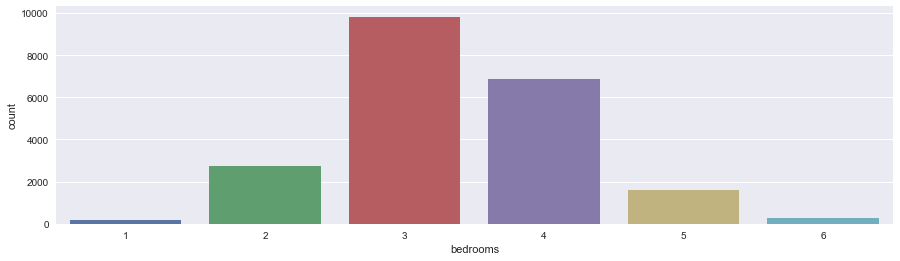

In [8]:
indexNames = df[ (df['bedrooms'] >= 7)].index
df.drop(indexNames, inplace=True)

indexNames = df[ (df['bedrooms'] == 0)].index
df.drop(indexNames , inplace=True)

plt.figure(figsize=(15,4))
sns.set(style="darkgrid")
ax = sns.countplot(x="bedrooms", data=df)

#removed sales with no 0 and 8 or more bedrooms

## Bathrooms:

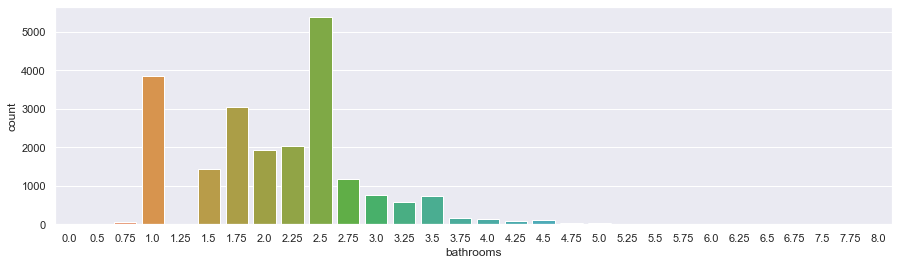

In [14]:
plt.figure(figsize=(15,4))

sns.set(style="darkgrid")
ax = sns.countplot(x="bathrooms", data=df)

You have to pee? Sorry! Removed sales with less than 1 bathroom, is it really a house if there isn't a washroom?

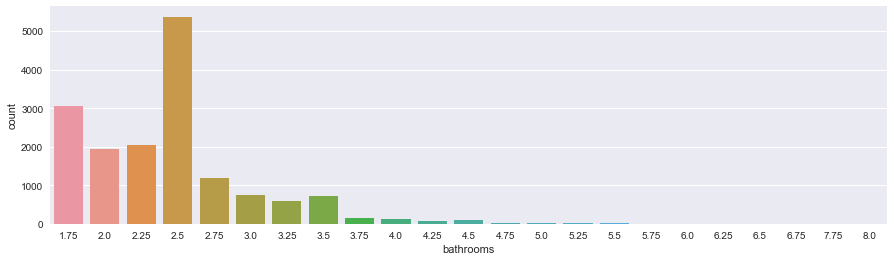

In [9]:
indexNames = df[ (df['bathrooms'] <= 1.5)].index
df.drop(indexNames , inplace=True)

plt.figure(figsize=(15,4))

sns.set(style="darkgrid")
ax = sns.countplot(x="bathrooms", data=df)

## Floors:

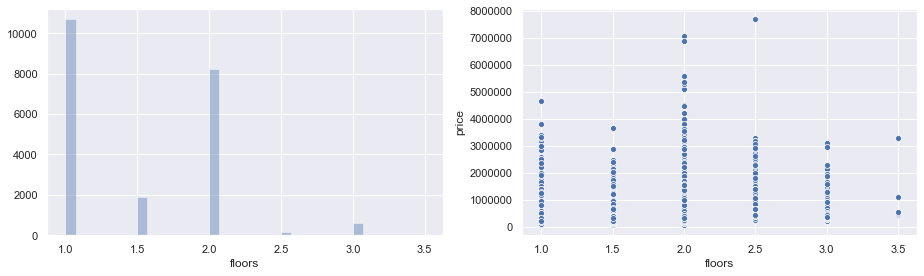

In [33]:
BR = df.groupby('floors').count()

f, axes = plt.subplots(1,2,figsize=(13,4))

sns.distplot(df['floors'],kde=False,ax=axes[0])
sns.scatterplot(x="floors",y='price',data=df,ax=axes[1])
f.tight_layout()

Homes with 1 or 2 floors is most common.  
More floors does not add to the value, possibly because they are tall split level homes, and more stairs is not always ideal.

# Age of the Home

Does the age of the home contribute to the prediction of the value? There are century homes and new builds included in this analysis.

In [45]:
# The date sold column has to be cleaned to extract the years the building was sold from the text string
df['yearSold'] = df['date'].astype(str).str[0:4]
df = df.astype({"yearSold": int})

#Calculate the age of the home at time of sale from the year it sold to the date t was built
df['ageAtSale'] = df['yearSold']-df['yr_built']
#df['ageAtSale'].unique()

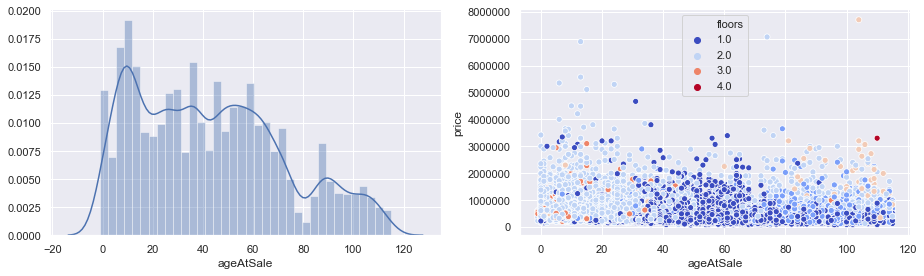

In [44]:
f2, axes = plt.subplots(1,2,figsize=(13,4))

sns.distplot(df['ageAtSale'],kde=True,ax=axes[0])
sns.scatterplot(x="ageAtSale",y='price',data=df,ax=axes[1],hue='floors',palette='coolwarm')
f2.tight_layout()

Single floor homes were more common in 40-80 year old homes, so those built 1940-1980, with no obvious impact on price.
Homes with an age less than 1 are new builds, and completed after the home was purchased.

In [46]:
#New build homes
df[df.ageAtSale  == -1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yearSold,ageAtSale
1763,1832100030,20140625T000000,597326.0,4,4.00,3570,8250,2.0,0,0,...,710,2015,0,98040,47.5784,-122.226,2230,10000,2014,-1
2687,3076500830,20141029T000000,385195.0,1,1.00,710,6000,1.5,0,0,...,0,2015,0,98144,47.5756,-122.316,1440,4800,2014,-1
7526,9520900210,20141231T000000,614285.0,5,2.75,2730,6401,2.0,0,0,...,0,2015,0,98072,47.7685,-122.160,2520,6126,2014,-1
8039,1250200495,20140624T000000,455000.0,2,1.50,1200,1259,2.0,0,0,...,200,2015,0,98144,47.6001,-122.298,1320,1852,2014,-1
14489,2770601530,20140826T000000,500000.0,2,2.25,1570,1269,2.0,0,0,...,290,2015,0,98199,47.6514,-122.385,1570,6000,2014,-1
17098,9126100346,20140617T000000,350000.0,3,2.00,1380,3600,3.0,0,0,...,0,2015,0,98122,47.6074,-122.305,1480,3600,2014,-1
19805,9126100765,20140801T000000,455000.0,3,1.75,1320,1014,3.0,0,0,...,0,2015,0,98122,47.6047,-122.305,1380,1495,2014,-1
20770,9310300160,20140828T000000,357000.0,5,2.50,2990,9240,2.0,0,0,...,0,2015,0,98133,47.7384,-122.348,1970,18110,2014,-1
20852,1257201420,20140709T000000,595000.0,4,3.25,3730,4560,2.0,0,0,...,970,2015,0,98103,47.6725,-122.330,1800,4560,2014,-1
20963,6058600220,20140731T000000,230000.0,3,1.50,1040,1264,2.0,0,0,...,140,2015,0,98144,47.5951,-122.301,1350,3000,2014,-1


In [16]:
#Could combine the year built and year removated to years since new as a variable. 
#Would an old, renovated house would be similar to a new house?
df['yr_renovated'].unique()

#Notice homes not renovated are labelled as 0

array([1991,    0, 2002, 2010, 1999, 1992, 2013, 1994, 1978, 2008, 2003,
       2011, 1974, 2014, 1983, 1945, 1990, 1988, 2005, 1957, 2000, 1998,
       1995, 1970, 1984, 1989, 2004, 2009, 2007, 2006, 1985, 2001, 1986,
       1979, 1997, 2015, 1968, 2012, 1963, 1987, 1993, 1962, 1977, 1996,
       1981, 1972, 1980, 1953, 1955, 1950, 1956, 1982, 1971, 1969, 1958,
       1975, 1976, 1964, 1973, 1967, 1934, 1965, 1944, 1960], dtype=int64)

In [47]:
#Extract the actual date sold for plotting in timeseries
df['DateSold'] = df['date'].astype(str).str[0:8]

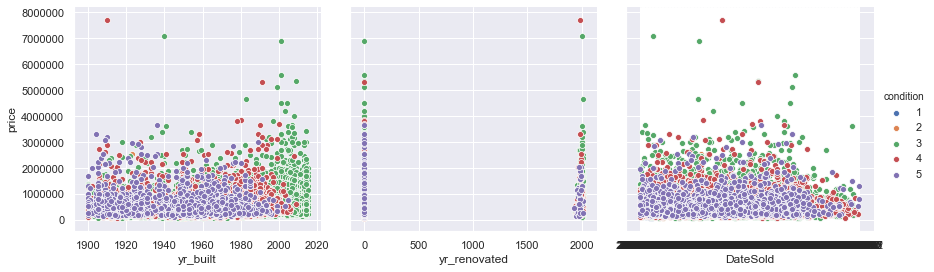

In [54]:
#Compare the age variables for homes with the sale price. Home condition is clearly correlated with price
f3=sns.pairplot(df,x_vars=['yr_built','yr_renovated','DateSold'], y_vars=['price'],hue='condition',height = 4)

# Home Condition

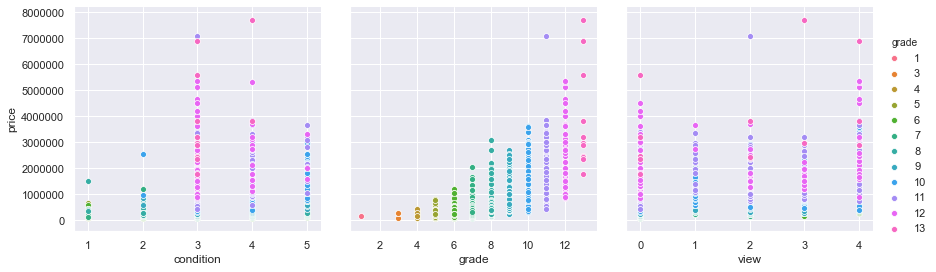

In [55]:
sns.pairplot(df,x_vars=['condition','grade','view'], y_vars=['price'],hue='grade',height = 4)

Condition and grade have a clear impact on sale price, view category 0 and 4 also seem influential, but the dataset does not describe this variable in detail.


# Create the Feature Table

Our analysis will therefore focus on 11 variables, listed below.

In [115]:
# Dropped features: ['id','sqft_living',sqft_lot','sqft_basement','yr_renovated', 'zipcode','lat', 'long', 'sqft_living15', 'sqft_lot15']
df = df[['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'yr_built', 'zipcode','ageAtSale','price']]
colNames = list(df)
print('Important features: ',colNames)
print('Total number of feature in analysis: ',len(colNames))

Important features:  ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'yr_built', 'zipcode', 'ageAtSale', 'price']
Total number of feature in analysis:  11


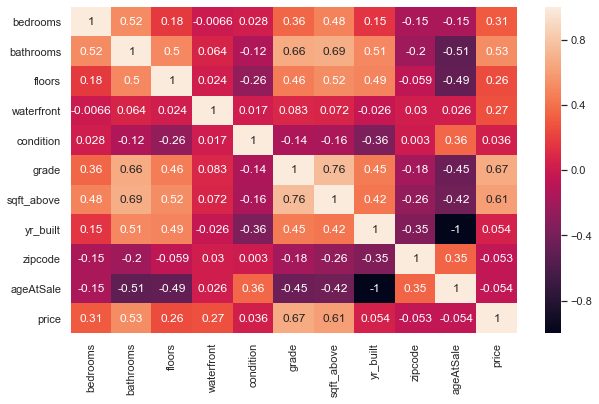

In [171]:
#Heat map showing the correlation between the variables and price.  Age at sale has the lowest correlation.
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)

## Create feature and target columns

In [117]:
# Features
x_columns  = len(colNames)-1
X = df.iloc[:,0:x_columns].values  

#Target is price, in last column of the dataframe
y = df.iloc[:,x_columns].values

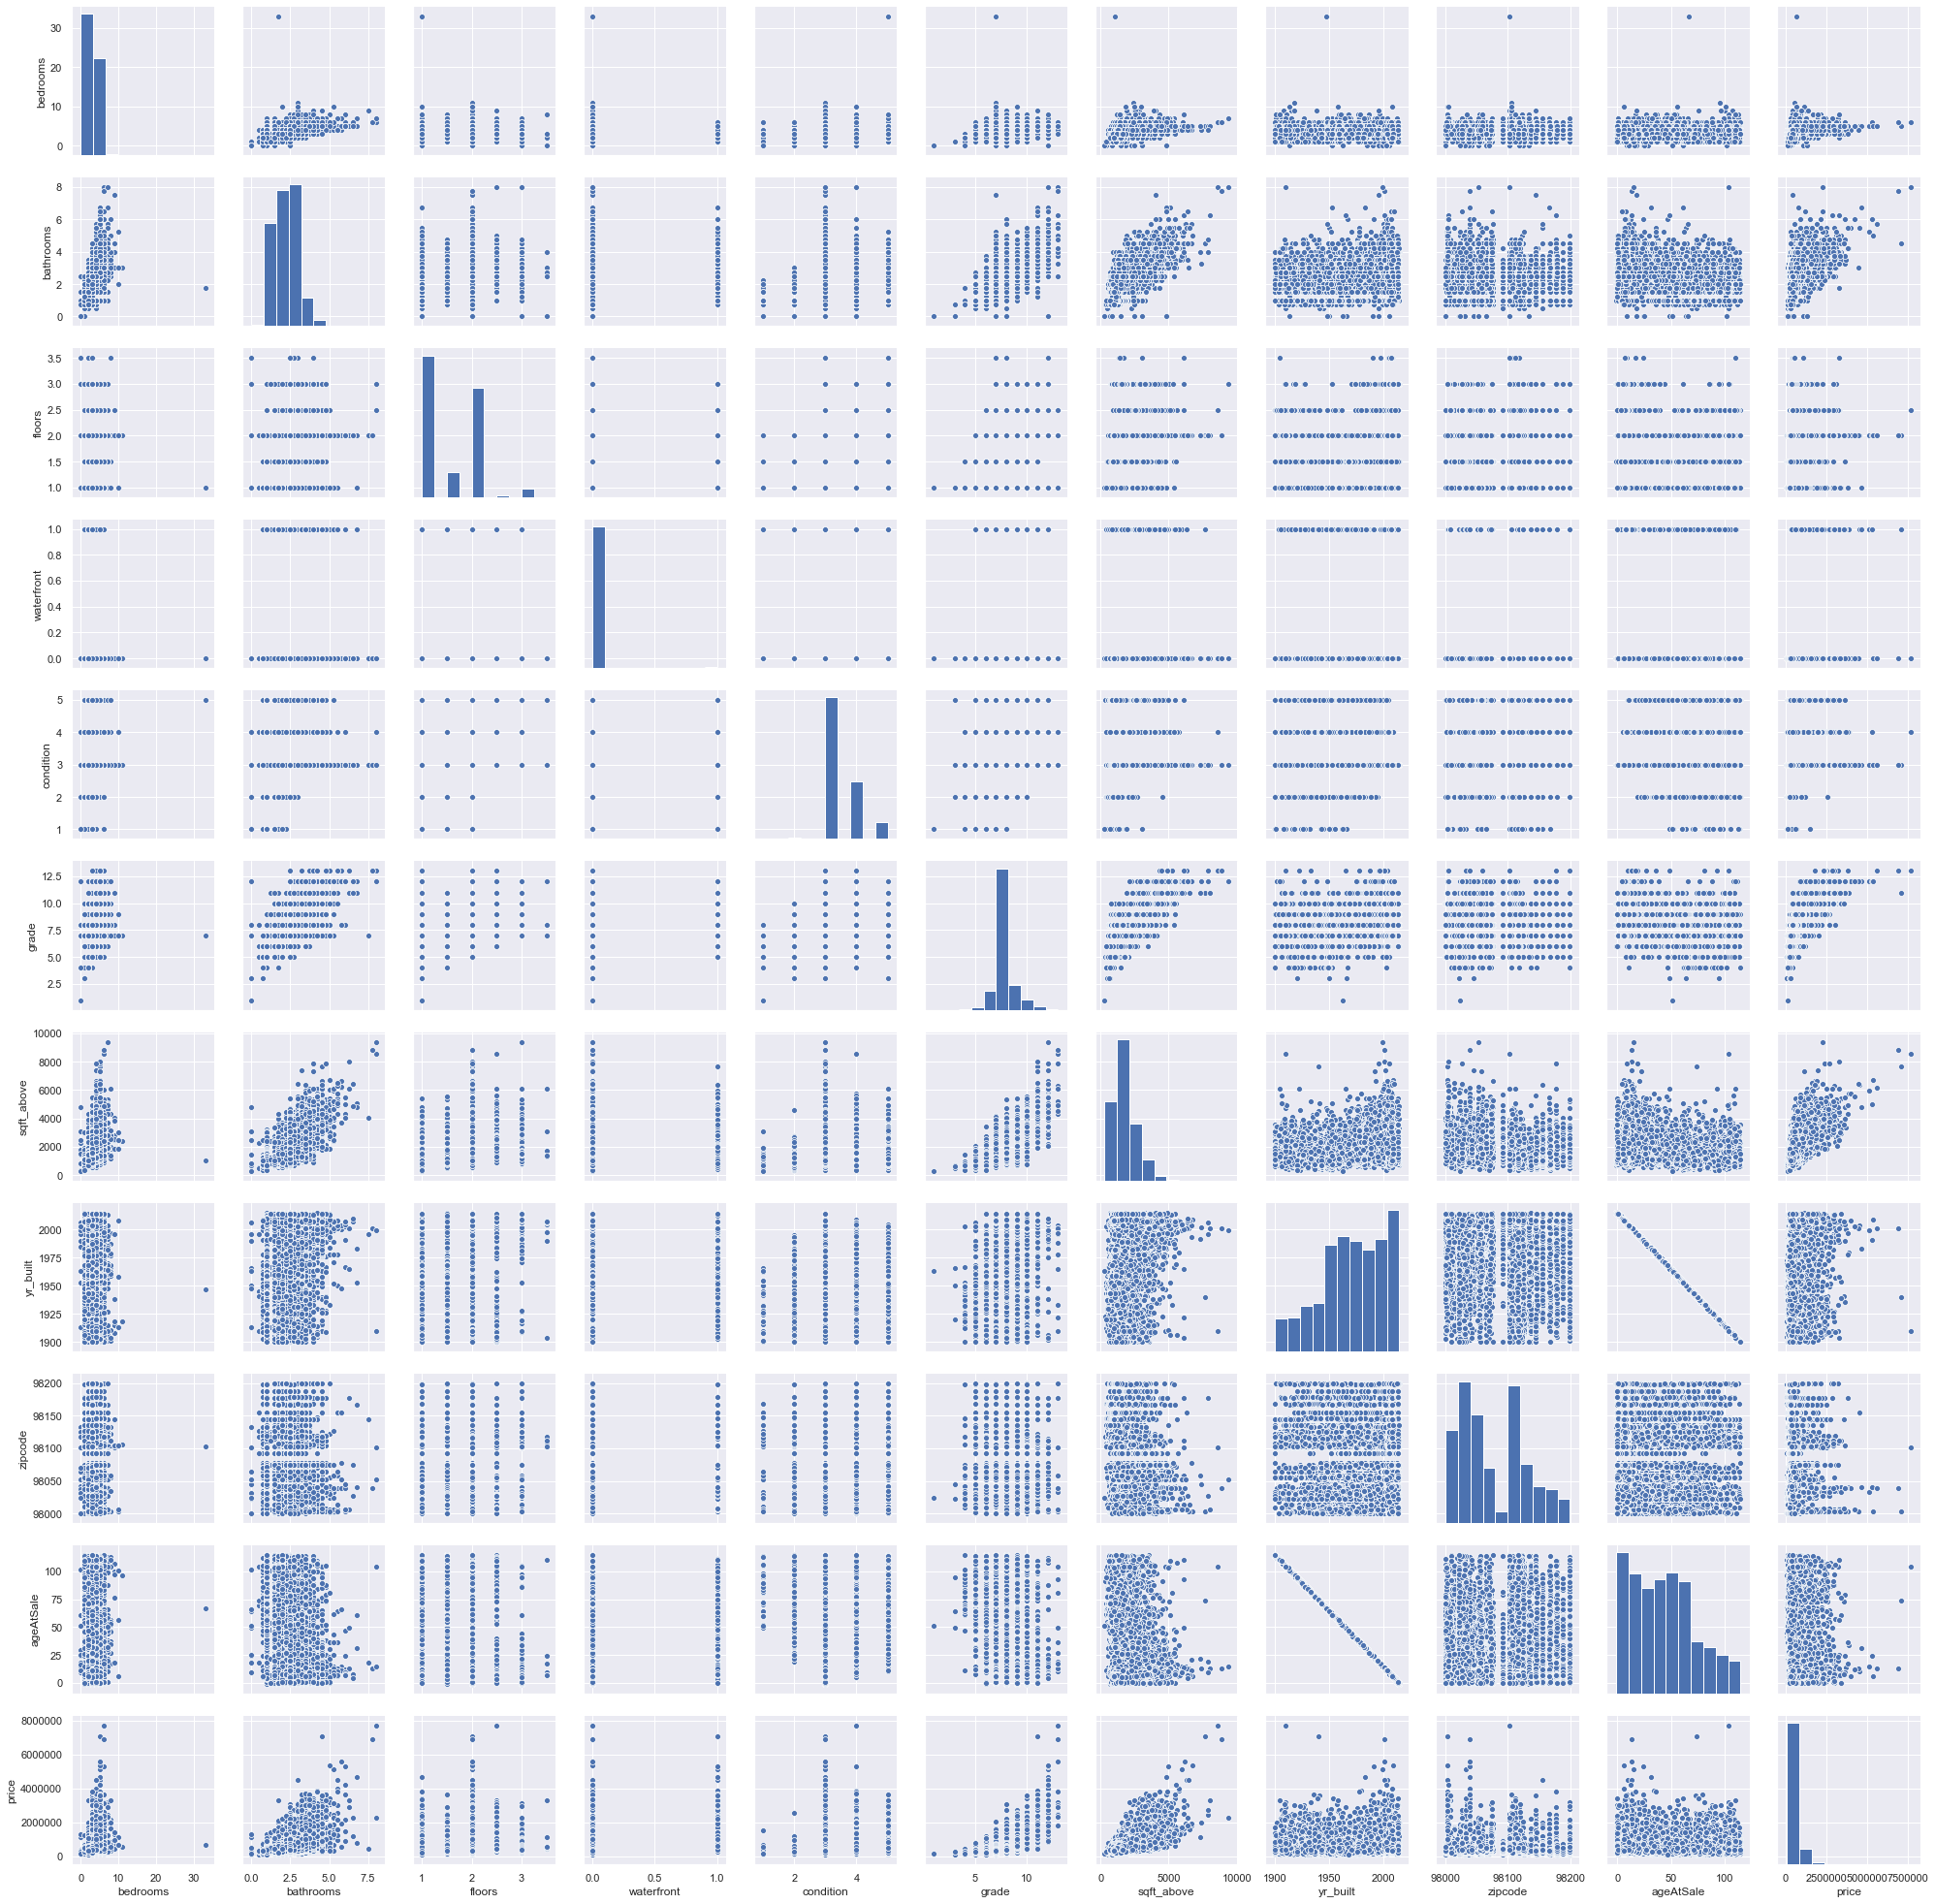

In [118]:
sns.pairplot(df)

# Create the Models

In [119]:
#Creat training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Assign features to a list
colNames = list(df)
model_scores=[]

## Linear Regression

In [121]:
model = LinearRegression()

In [122]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
scoreLR = model.score(x_test, y_test)
print(scoreLR)

0.6125558132985182


## Polynomial Regression

In [130]:
# for polynomial analysis, we have to transform the data

scoresPR = []
for i in range(1,4):
    poly=PolynomialFeatures(degree=i)
    x_poly = poly.fit_transform(X)
    
    x_trainp, x_testp, y_trainp, y_testp = train_test_split(x_poly, y, test_size=0.2, random_state=0)
    
    model = LinearRegression()
    model.fit(x_trainp, y_trainp)
    
    score = model.score(x_testp, y_testp)
    scoresPR.append(score)
    scorePR = max(scoresPR)

print('Max polynomial score is: ',scorePR)

Max polynomial score is:  0.6792047427470167


## SVR Linear Regression

In [70]:
#3 - Try the SVR linear regression

modelSVR = SVR(kernel='linear').fit(x_train, y_train)
y_pred = modelSVR.predict(x_test)

print(mean_squared_error(y_test, y_pred))

scoreSVR = modelSVR.score(x_test, y_test)
print('Linear SVR Model gives a score of: ',scoreSVR)


72547160159.56624
Linear SVR Model gives a score of:  0.38997178129720367


## SVR Polynomial Regression

In [138]:
deg = 3

modelSVRpoly = SVR(kernel='poly',degree=deg,gamma='auto',tol = 0.001, max_iter = 100000 ).fit(x_train, y_train)
y_pred = modelSVRpoly.predict(x_test)

print('Degrees of ',deg,'Mean square error:',mean_squared_error(y_test, y_pred))

scoreSVRpoly = modelSVRpoly.score(x_test, y_test)

scoreSVRpoly=0
print('Polynomial SVR Model gives a score of: ',scoreSVRpoly)
       

Degrees of  3 Mean square error: 2.3226715356479267e+41
Polynomial SVR Model gives a score of:  0


## KNN Regression

In [85]:
#5 -  Try the KNN regression
tempScore=[]
for i in range(15,25,1):
    modelKNN = KNeighborsRegressor(n_neighbors=i).fit(x_train, y_train)

    score = modelKNN.score(x_test, y_test)
    tempScore.append(score)
    print(i, 'gives a score of: ',score)
scoreKNN = max(tempScore)  

print('KNN Regression gives a score of:', scoreKNN)

15 gives a score of:  0.44408412760245874
16 gives a score of:  0.44697517216831306
17 gives a score of:  0.447690626752434
18 gives a score of:  0.449111658575824
19 gives a score of:  0.45074088576159965
20 gives a score of:  0.4533060915571733
21 gives a score of:  0.45352508638051436
22 gives a score of:  0.4525284720157772
23 gives a score of:  0.449700768182694
24 gives a score of:  0.45014990712949843
KNN Regression gives a score of: 0.45352508638051436


## Decision Tree

In [88]:
# 6 - Do a Decision Tree regressor analysis
modelTree = DecisionTreeRegressor(random_state=0).fit(x_train, y_train)
y_pred = modelTree.predict(x_test) 

scoreDT=modelTree.score(x_test, y_test)
print(scoreDT)


0.5741767654939017


## Random Forest

In [160]:
# 7 - Do a Random Forest Regressor analysis
score=[]
estimator_num=[]
temp_score = []

for estimators in range (300,600,50):
    
    estimator_num.append(estimators)
    modelRandFor = RandomForestRegressor(n_estimators = estimators, random_state = 0).fit(x_train, y_train)
    y_predRF = modelRandFor.predict(x_test)
    
    score = (modelRandFor.score(x_test, y_test)).round(3)
    temp_score.append(score)

    print(estimators,'estimators gives a score of:',modelRandFor.score(x_test, y_test))

scoreRF = max(temp_score)
print('Random Forest Maximum Score is:',scoreRF)

300 estimators gives a score of: 0.7999264540299316
350 estimators gives a score of: 0.7996579787065365
400 estimators gives a score of: 0.8002098806107495
450 estimators gives a score of: 0.8006134165688606
500 estimators gives a score of: 0.7999074415204865
550 estimators gives a score of: 0.7996636337513847
Random Forest Maximum Score is: 0.801


# Summarize the Results

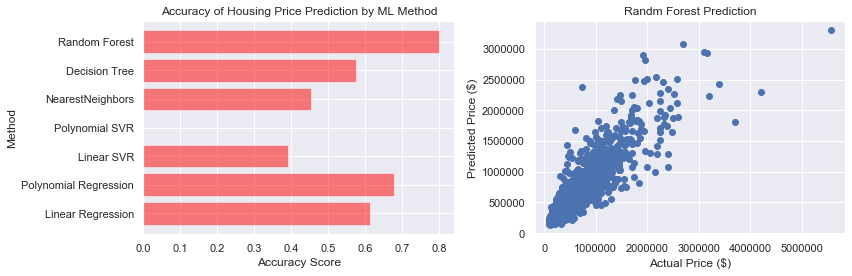

In [167]:
# Store all the model names and scores in lists to plot
model_names = ['Linear Regression','Polynomial Regression','Linear SVR','Polynomial SVR','NearestNeighbors', 'Decision Tree','Random Forest']
y_pos = np.arange(len(model_names))
model_scores = [scoreLR,scorePR,scoreSVR,scoreSVRpoly,scoreKNN,scoreDT,scoreRF]

fig3, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig3.tight_layout()

# Plot all method scores
ax1.barh(model_names,model_scores, align='center', alpha=0.5,color='red')
ax1.set_yticklabels(model_names)
ax1.set_ylabel('Method')
ax1.set_xlabel('Accuracy Score')
ax1.set_title('Accuracy of Housing Price Prediction by ML Method')

# Plot best predicton actual vs predicted prices
ax2.scatter(y_test,y_predRF)
ax2.set_ylabel('Predicted Price ($)')
ax2.set_xlabel('Actual Price ($)')
ax2.set_title('Randm Forest Prediction')
fig3.tight_layout()

In this example, Random Forest gives the best prediction with an accuracy score of 80%.  The prediction is linear near the origin and then increases in variability. The model could potentially be improved with further feature engineering.

## Save the best model - Random Forest

In [168]:
#save the Random Forest model to disk
filename = 'KingCountyHousePiceRF.sav'
pickle.dump(modelRandFor, open(filename, 'wb'))

In [ ]:
#Load the model at some point in the future
KCH_1 = pickle.load(open('KingCountyHousePiceRF.sav','rb'))